<a href="https://colab.research.google.com/github/yamaseraph/Air-Pollutant-Analysis/blob/main/Su's_ETL_for_Air_Pollutant_State_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Read raw data

In [5]:
data_raw = pd.read_excel('state_trends.xlsx', )#this is the original data with 50 states https://docs.google.com/spreadsheets/d/1MoQIJbRDhZVrRgZtiu5uheAM_TIPe8hh/edit?usp=sharing&ouid=108507788535088793375&rtpof=true&sd=true
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State FIPS          6727 non-null   int64  
 1   State               6649 non-null   object 
 2   Tier 1 Code         6727 non-null   int64  
 3   Tier 1 Description  6649 non-null   object 
 4   Pollutant           6727 non-null   object 
 5   emissions2002       6649 non-null   float64
 6   emissions2003       6649 non-null   float64
 7   emissions2004       6649 non-null   float64
 8   emissions2005       6649 non-null   float64
 9   emissions2006       6649 non-null   float64
 10  emissions2007       6649 non-null   float64
 11  emissions2008       6649 non-null   float64
 12  emissions2009       6649 non-null   float64
 13  emissions2010       6649 non-null   float64
 14  emissions2011       6649 non-null   float64
 15  emissions2012       6649 non-null   float64
 16  emissi

## Transform (melt) columns for years into cells

In [ ]:
# Get the names of the "value" columns (i.e. those with pollutant measurements for each year)
value_cols = [col for col in data_raw.columns if col.startswith('emissions')]

# Get the other column names, which are "id columns", which contain other data we might want to group or sort by
id_cols = [col for col in data_raw.columns if not col.startswith('emissions')]

print("value columns:", value_cols)
print("identifier columns: ", id_cols)

In [ ]:
# Now use the 'melt' function to create a column called 'year' and the corresponding value from each of the value columns
data_melted = pd.melt(data_raw, value_vars=value_cols, id_vars=id_cols, var_name='year', value_name='emissions')

# Convert the year values (e.g. "emissions2017") to integer years
data_melted['year'] = data_melted['year'].str.lstrip('emissions').astype(int)

data_melted.info()

In [ ]:
# Show a sample of the data, for familiarity
data_melted.sample(25)

In [ ]:
total_emissions = data_melted.groupby('year')['emissions'].sum() #grouping years with emissions
# year is index

total_emissions.info()

In [ ]:
total_emissions

## Combine sums for each pollutant

If we look at the data above, we can notice that each year can have multiple entries for both pollutants and categories. That is, pollutants can belong to move than one category (e.g. S02 belongs to both Fuel Comb. Other and Storage & Transport tiers) and each category has more than one pollutant type (e.g. Metals Processing has both CO and NH3 pollutants). As a result, each year has mutliple readings. To reduce this problem, we can combine the tiers so that each pollutant type appears only once per year per state.

This isn't necessarily better than the datatypes above, but it can provide alternative insights to the data.

In [ ]:
# We want one entry per year per state per pollutant, so we group by year, state, and pollutant and sum the emissions
data_reduced = data_melted.groupby(by=['year', 'State', 'Pollutant'], as_index=False)['emissions'].sum()
data_reduced.info()

# Visualize

Here are a few visualizations that might help you develop an intuition for this Air Quality data.

### Emissions over time (linear scaling)

This is a simple plot of each emission type over the years, but because some are so much less prevalent than others, there's a lot of overlap

In [2]:
import numpy as np
# Set up the base figure elements
fig, ax = plt.subplots(figsize=(15,8))

# Plot the lines - years on x axis, emissions on y, and give a different line to each pollutant group
sea.lineplot(data=data_melted, x='year', y='emissions', hue='Pollutant', ax=ax, palette='pastel')

# Style the elements for better readability - these values are mostly trial and error
ax.legend(bbox_to_anchor=(1.25, 1.0))


NameError: ignored

### Emissions over time (log scaling)

This is the same plot as above, but the y-axis will be scaled logarithmically, giving better visibility to emissions with lower values compared to the maximum.

This makes the variability in wildfire emissions a lot more apparent

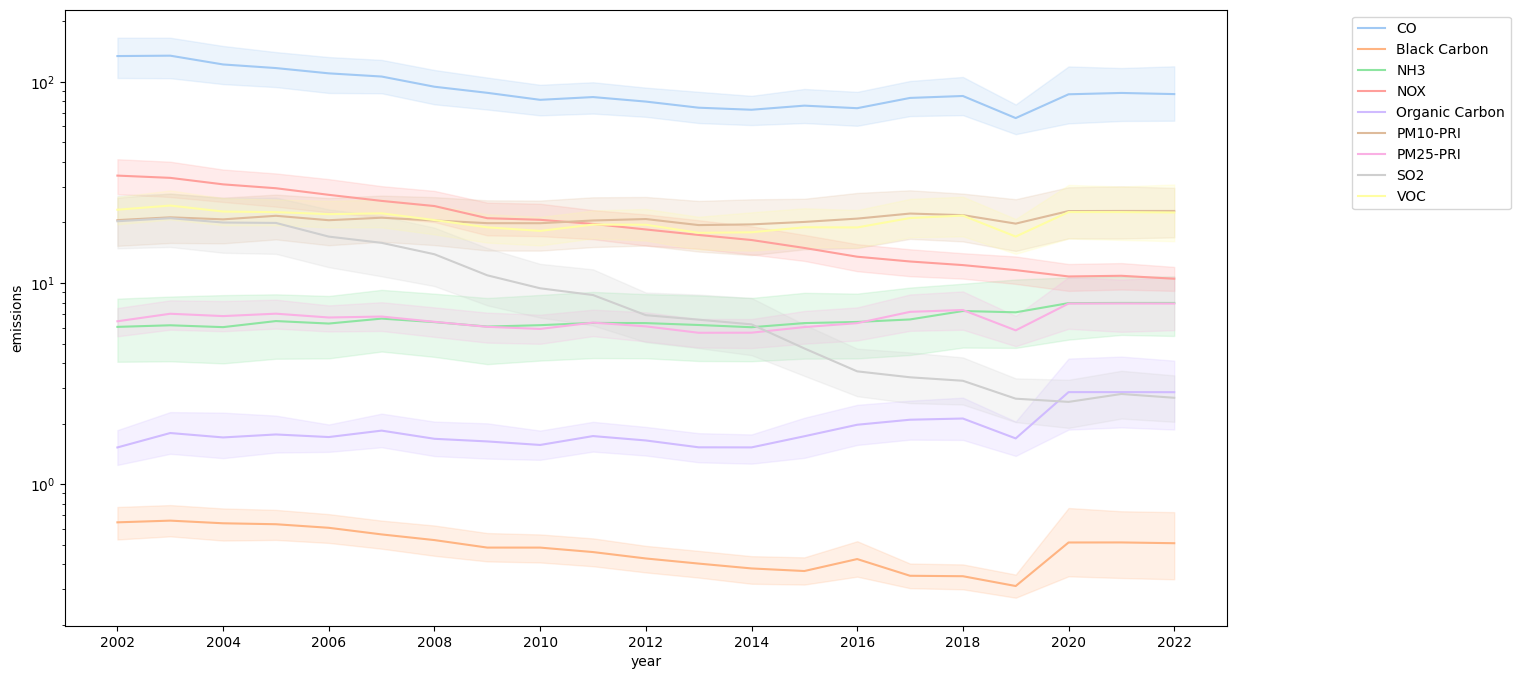

In [ ]:
import numpy as np
# Set up the base figure elements
fig, ax = plt.subplots(figsize=(15,8))

# Plot the lines - years on x axis, emissions on y, and give a different line to each pollutant group
sea.lineplot(data=data_melted, x='year', y='emissions', hue='Pollutant', ax=ax, palette='pastel')

# Style the elements for better readability - these values are mostly trial and error
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.xticks(np.arange(2002, 2023, step=2))
plt.yscale('log')

### Emissions by state (single year)
To see how states differ for each pollutant, we can make use of heatmaps. As before, some emissions (namely CO) are much higher in emissions than other pollutants, so we need to apply a logarithmic scale to the color bar.

Doing so lets us see that California, Texas, and Oregon are high contributors across many emissions, while Colorado, Connecticut, Hawai'i, Rhode Island, and Vermont are particularly low contributors, at least for 2022.

You can replace the selected year to see trends from other times.

<Axes: xlabel='State', ylabel='Pollutant'>

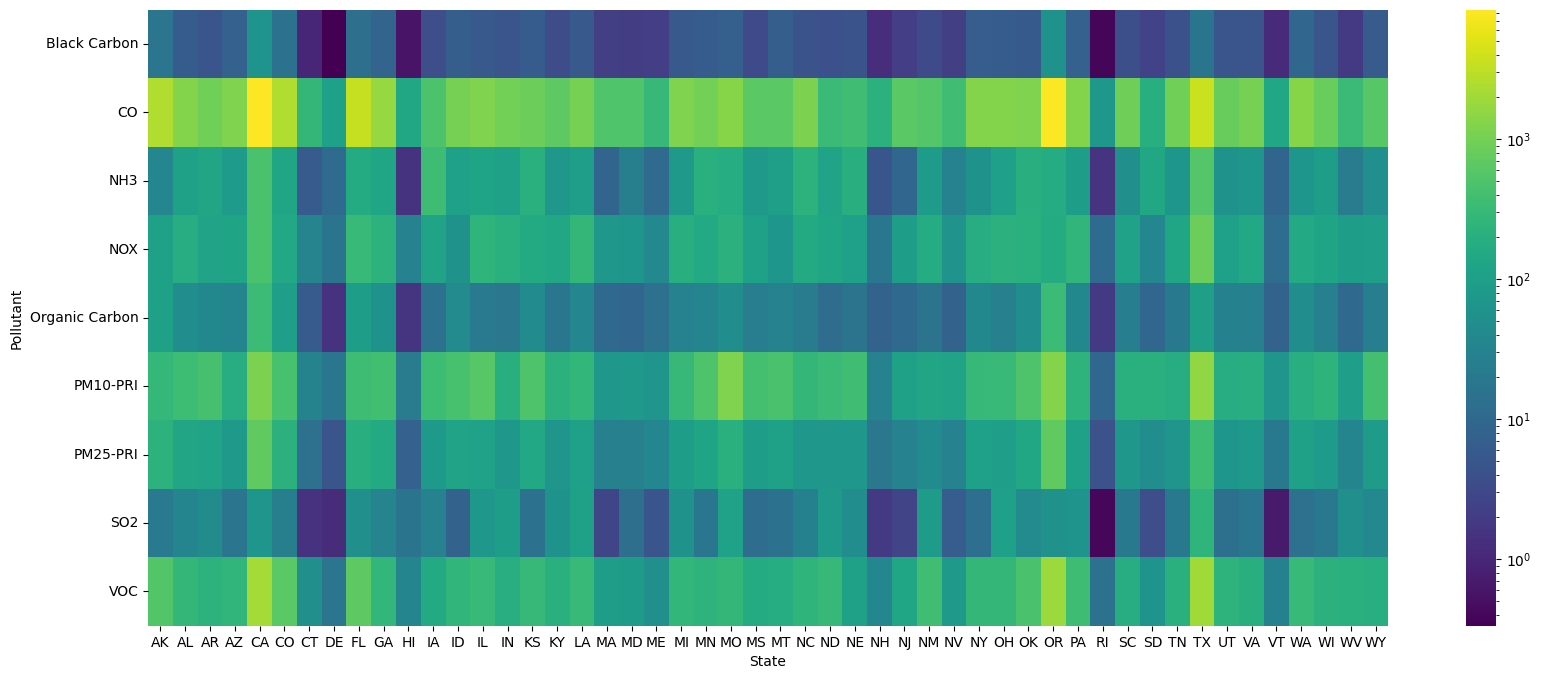

In [ ]:
year_selection = 2022
heatmap_data = data_reduced.query('year == @year_selection').pivot(index='Pollutant', columns='State', values='emissions')

# Plot data for the year selected with a logarithmic color scale.
fig, ax = plt.subplots(figsize=(20, 8))
sea.heatmap(data=heatmap_data, cmap='viridis', norm=LogNorm(), ax=ax)

Alternatively, we can average across the years to see if there are any long-term trends.

<Axes: xlabel='State', ylabel='Pollutant'>

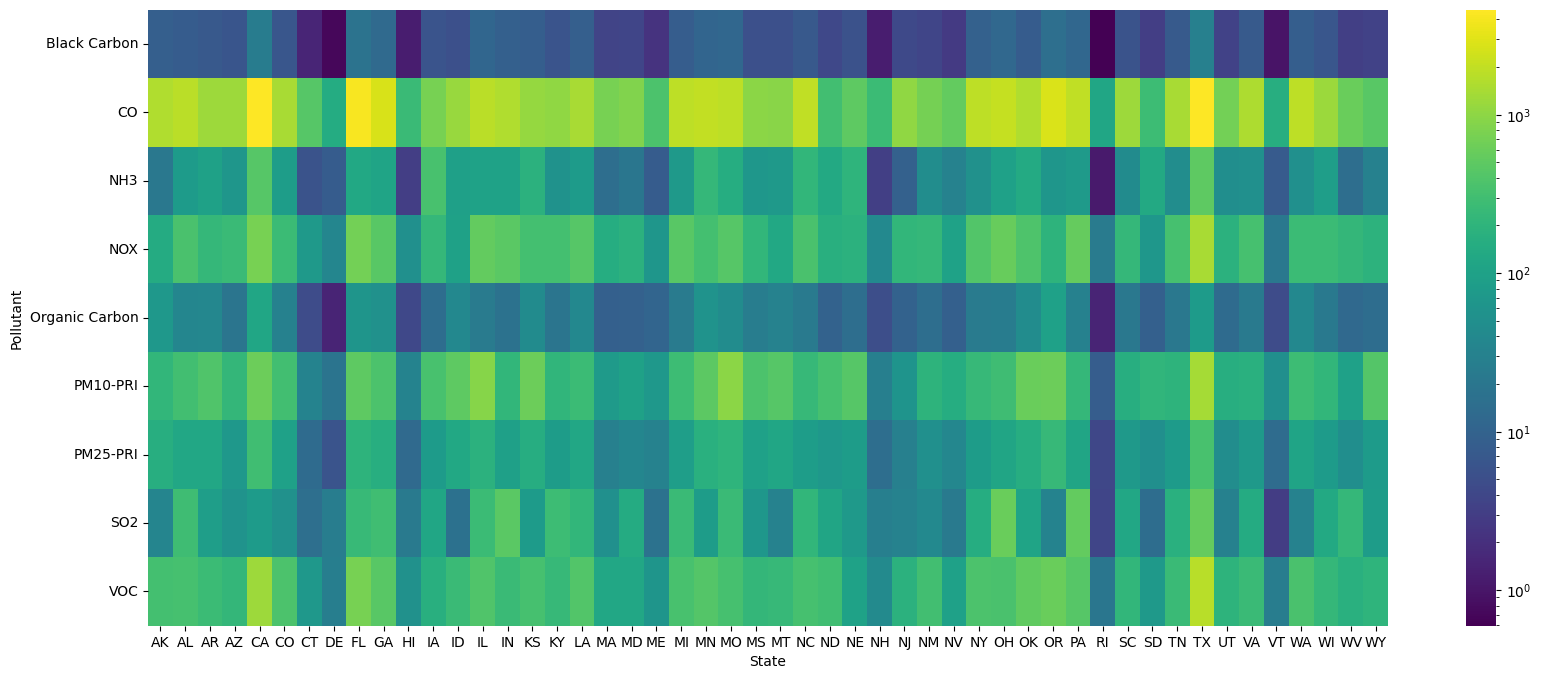

In [ ]:
# To average over years, group by the categorical variables (pollutants and states) and average the emissions column, then pivot. The year column ends up dropped implicitly
heatmap_data = data_reduced.groupby(by=['Pollutant', 'State'], as_index=False)['emissions'].mean().pivot(index='Pollutant', columns='State', values='emissions')

# Plot data for the year selected with a logarithmic color scale.
fig, ax = plt.subplots(figsize=(20, 8))
sea.heatmap(data=heatmap_data, cmap='viridis', norm=LogNorm(), ax=ax)

### Pollutants and Tiers

To cap of this investigation, we can explore some trends in the pollutants vs. Tiers. This heatmap lets us see any strong or very weak correlations between these tiers, especially if we visualize the median emission values. For instance, CO is heavily concentrated in the two highway-related categories, while the primary source of PM10 doesn't seem to fit well into any of the specific categories. We can also see that Solvent Utilization is just about entirely made up of VOC emissions. By looking at the "brightest" columns, we can also see which Tiers are the worst offenders for emissions.

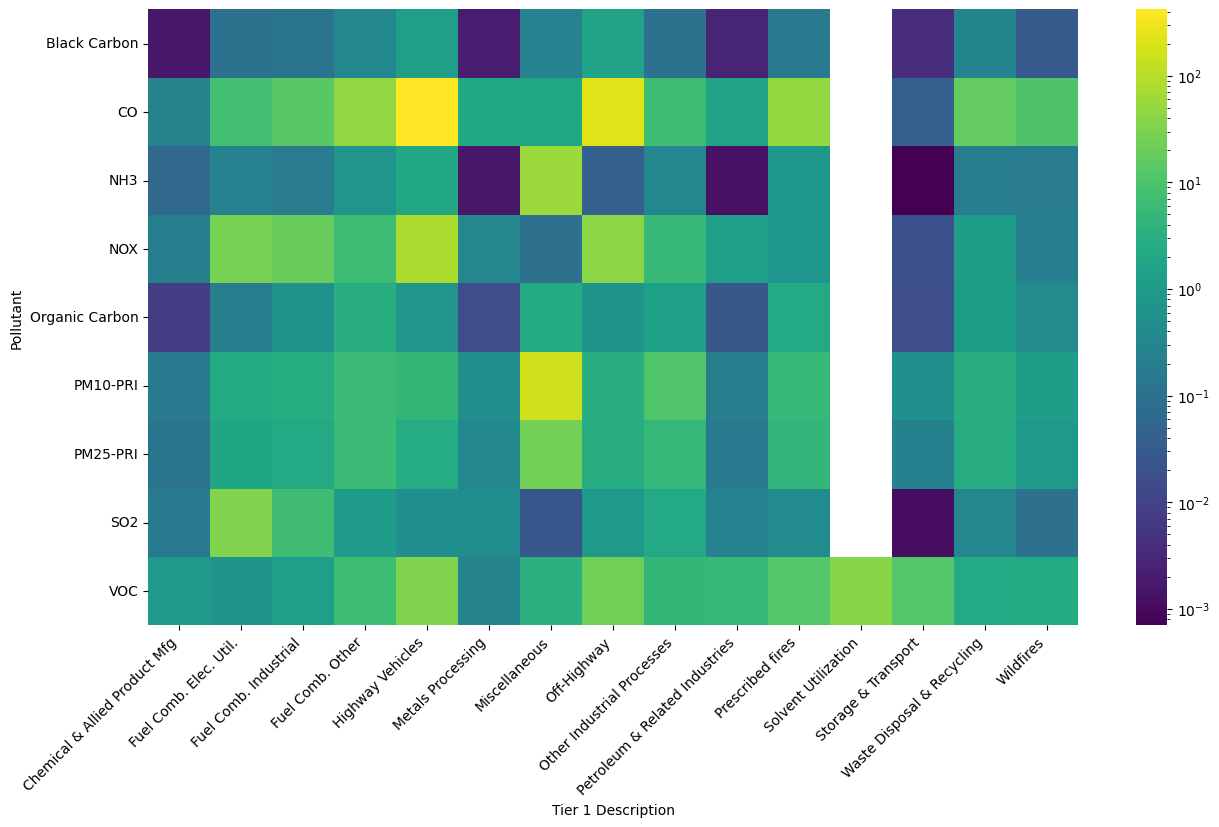

In [ ]:
heatmap_data = data_melted.groupby(by=['Tier 1 Description', 'Pollutant'], as_index=False)['emissions'].median().pivot(index='Pollutant', columns='Tier 1 Description', values='emissions')

# Plot and adjust xticks a bit
fig, ax = plt.subplots(figsize=(15, 8))
sea.heatmap(data=heatmap_data, cmap='viridis', norm=LogNorm(), ax=ax)
plt.xticks(rotation=45, ha='right')
print()

# Plotting Emissions data

**Plotting Emissions data (sum of diff emissions for diff years)**

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(timeseries):
  result= adfuller(timeseries)
  print(f'ADF Statistic {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'critical value: {result[4]}')


#check_stationary(data_reduced['emissions'])
check_stationary(total_emissions)

ADF Statistic -7.327598973365618
p-value: 1.1500853386091094e-10
critical value: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}


In [ ]:
"""emissions_df=data_reduced[['emissions']] #emissions df has emissions and year
emissions_df['shift']=emissions_df.emissions.shift()
emissions_df['shiftDiff'] = emissions_df['emissions']-emissions_df['shift']
emissions_df.head()
#idk"""

"emissions_df=data_reduced[['emissions']] #emissions df has emissions and year\nemissions_df['shift']=emissions_df.emissions.shift()\nemissions_df['shiftDiff'] = emissions_df['emissions']-emissions_df['shift']\nemissions_df.head()\n#idk"

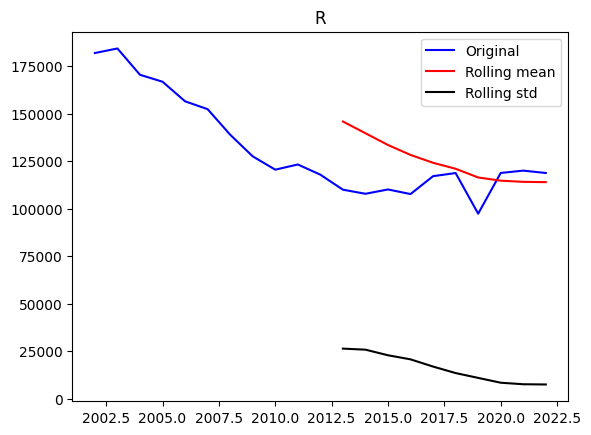

In [ ]:
#looking at original vs rolling mean vs rolling standard deviation
rolmean = total_emissions.rolling(window=12).mean()
rolstd = total_emissions.rolling(window=12).std()

orig = plt.plot(total_emissions,color='blue',label='Original')
mean = plt.plot(rolmean,color='red',label='Rolling mean')
std = plt.plot(rolstd, color='black',label='Rolling std')

plt.legend(loc='best')
plt.title('R')
plt.show()

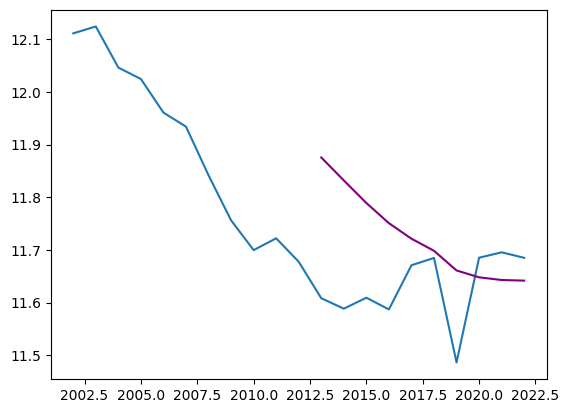

In [ ]:
#same thing as previous model, rolling mean and standard deviation but over log
import numpy as np

logScale= np.log(total_emissions)
movingAverage=logScale.rolling(window=12).mean()
movingSTD=logScale.rolling(window=12).std()

plt.plot(logScale)
plt.plot(movingAverage, color='purple')
plt.show()

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

#plt.plot(data_reduced.index, data_reduced['emissions'])
plt.show()

In [ ]:
#Train test split
to_row = int(len(total_emissions)*0.80)
training_data = list[total_emissions[0:to_row]]
testing_data=list[total_emissions[to_row:]]

"""to_row=int(len(data_reduced)*0.9)
training_data = list[data_reduced[0:to_row]['emissions']]
testing_data=list[data_reduced[to_row:]['emissions']]
training_data"""

"""data_melted.drop(['State FIPS','State','Tier 1 Code','Tier 1 Description','Pollutant'],axis=1)
to_row = int(len(data_melted)*0.9) #90% of data will be used for data training
training_data = list[data_melted[0:to_row]['emissions']]
testing_data=list[data_melted[to_row:]['emissions']]"""

"data_melted.drop(['State FIPS','State','Tier 1 Code','Tier 1 Description','Pollutant'],axis=1)\nto_row = int(len(data_melted)*0.9) #90% of data will be used for data training\ntraining_data = list[data_melted[0:to_row]['emissions']]\ntesting_data=list[data_melted[to_row:]['emissions']]"

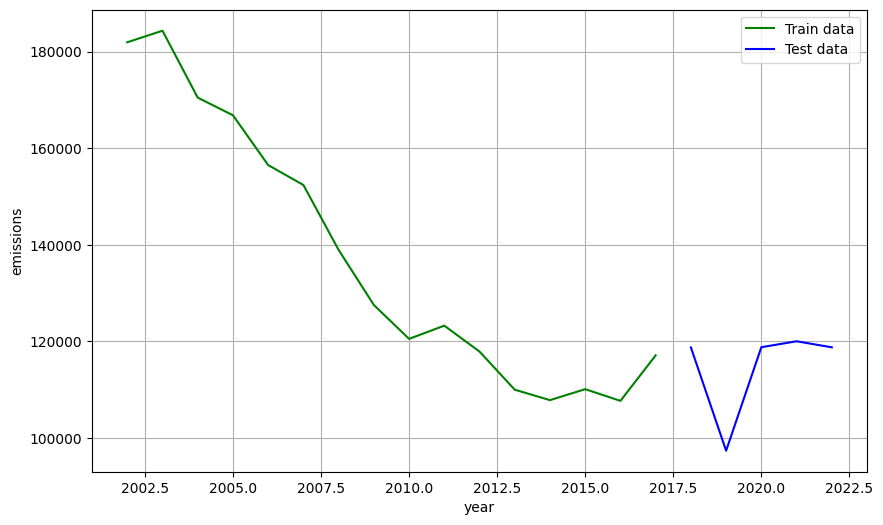

In [ ]:
#split data into train and training set
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('year')
plt.ylabel('emissions')
plt.plot(total_emissions[0:to_row],'green',label='Train data')
plt.plot(total_emissions[to_row:],'blue', label='Test data')
plt.legend()

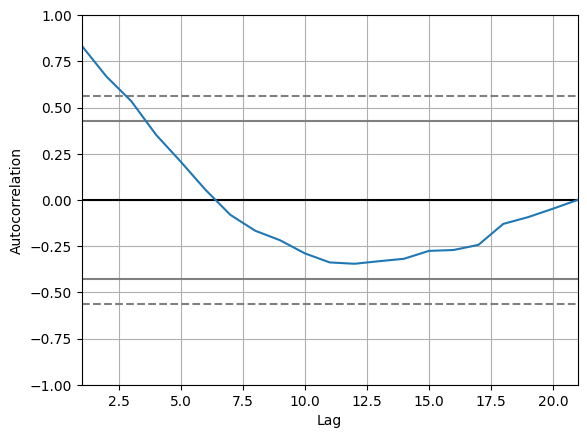

In [ ]:
#plot autocorrelations (from here, i'm following tutorial from https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot


#data1=data_melted.drop(['State FIPS','State','Tier 1 Code','Tier 1 Description','Pollutant'],axis=1)
autocorrelation_plot(total_emissions)
pyplot.show()

In [ ]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA


#fitting model
model = ARIMA(total_emissions, order=(5,1,0)) #model
model_fit=model.fit()  #fitting the model

#summary of fitting the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              emissions   No. Observations:                   21
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -210.239
Date:                Sun, 03 Dec 2023   AIC                            432.478
Time:                        23:14:49   BIC                            438.453
Sample:                             0   HQIC                           433.645
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0113      0.154      0.074      0.941      -0.290       0.312
ar.L2         -0.0729      0.197     -0.371      0.711      -0.458       0.313
ar.L3         -0.0011      0.123     -0.009      0.9

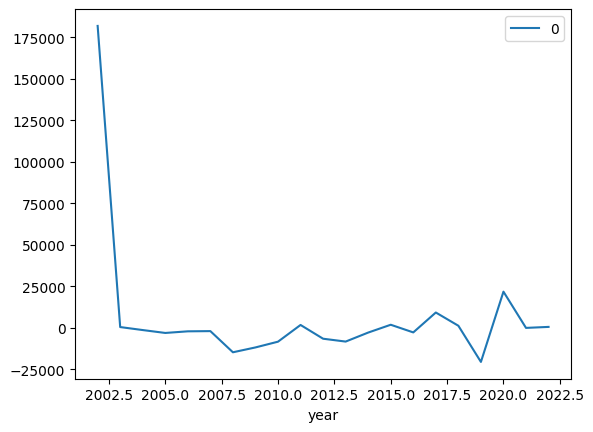

In [ ]:
#line plot of residuals
residuals=DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

<function matplotlib.pyplot.show(close=None, block=None)>

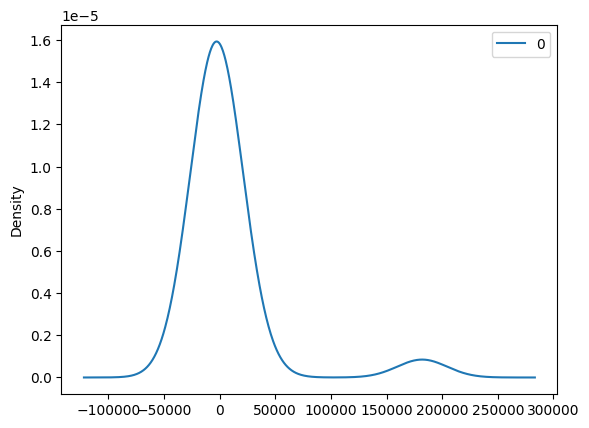

In [ ]:
#density plot of residuals --> diff btwn predictions vs expected; close to 0 so lower error
#note1: can try out pollutants without summing; group by pollutants, train on one pollutant, then try for diff one
#note2: grid search can help with P,D,Q parameters (https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
#note3: choropleth to graph dif pollutants on states
residuals.plot(kind='kde')
pyplot.show

In [ ]:
#summary stats of residuals
print(residuals.describe())

                   0
count      21.000000
mean     6314.080300
std     41137.588111
min    -20646.331600
25%     -6654.005129
50%     -2069.392729
75%      1166.175930
max    181956.669621


                               SARIMAX Results                                
Dep. Variable:              emissions   No. Observations:                   21
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -210.239
Date:                Sun, 03 Dec 2023   AIC                            432.478
Time:                        23:15:14   BIC                            438.453
Sample:                             0   HQIC                           433.645
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0113      0.154      0.074      0.941      -0.290       0.312
ar.L2         -0.0729      0.197     -0.371      0.711      -0.458       0.313
ar.L3         -0.0011      0.123     -0.009      0.9

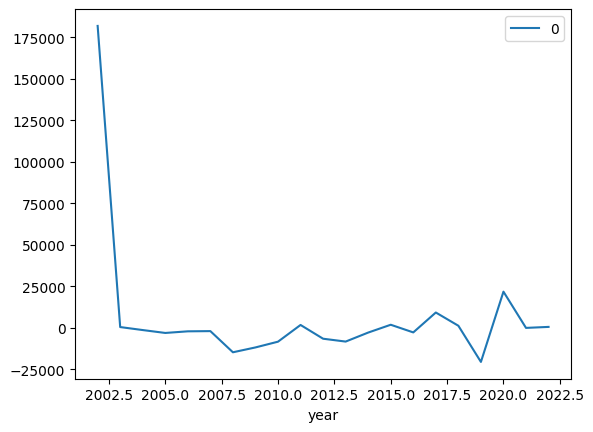

                   0
count      21.000000
mean     6314.080300
std     41137.588111
min    -20646.331600
25%     -6654.005129
50%     -2069.392729
75%      1166.175930
max    181956.669621


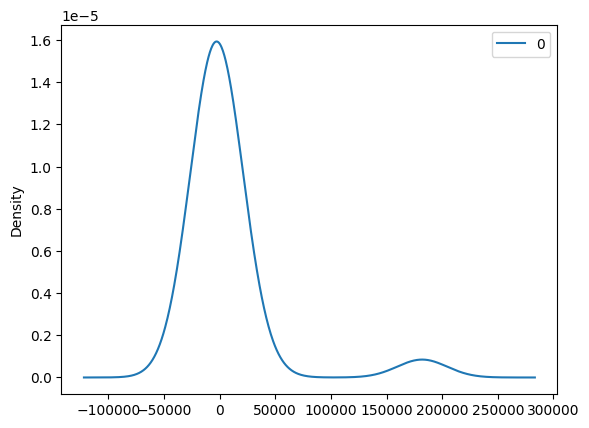

In [ ]:
#same thing as above, just putting everything above together
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot


# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA


#fitting model
model = ARIMA(total_emissions, order=(5,1,0)) #model
model_fit=model.fit()  #fitting the model

#summary of fitting the model
print(model_fit.summary())

#line plot of residuals
residuals=DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

#density plot of residuals
residuals.plot(kind='kde')
pyplot.show

#summary stats of residuals
print(residuals.describe())

# Using Grid Search to see which p,d,q parameters best fit our total_emissions model

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.80) #training with 80% of data
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

"""# load dataset
series = total_emissions
"""
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(total_emissions.values, p_values, d_values, q_values)
#Based on our result: best ARIMA(1, 1, 1) RMSE=13255.383

ARIMA(0, 0, 0) RMSE=21973.752
ARIMA(0, 0, 1) RMSE=16110.457
ARIMA(0, 0, 2) RMSE=20987.832
ARIMA(0, 1, 0) RMSE=13591.914
ARIMA(0, 1, 1) RMSE=13782.928
ARIMA(0, 1, 2) RMSE=13579.321
ARIMA(0, 2, 0) RMSE=23843.456
ARIMA(0, 2, 1) RMSE=24896.110
ARIMA(0, 2, 2) RMSE=23717.158
ARIMA(1, 0, 0) RMSE=13442.206
ARIMA(1, 0, 1) RMSE=15615.635
ARIMA(1, 0, 2) RMSE=18149.917
ARIMA(1, 1, 0) RMSE=13758.155
ARIMA(1, 1, 1) RMSE=13255.383
ARIMA(1, 1, 2) RMSE=13876.584
ARIMA(1, 2, 0) RMSE=24800.480
ARIMA(1, 2, 1) RMSE=24731.985
ARIMA(1, 2, 2) RMSE=24826.998
ARIMA(2, 0, 0) RMSE=16491.686
ARIMA(2, 0, 1) RMSE=15336.519
ARIMA(2, 0, 2) RMSE=18993.595
ARIMA(2, 1, 0) RMSE=13619.680
ARIMA(2, 1, 1) RMSE=13850.270
ARIMA(2, 1, 2) RMSE=13542.376
ARIMA(2, 2, 0) RMSE=23750.911
ARIMA(2, 2, 1) RMSE=24864.583
ARIMA(2, 2, 2) RMSE=23554.290
ARIMA(4, 0, 0) RMSE=16481.805
ARIMA(4, 0, 1) RMSE=16732.495
ARIMA(4, 0, 2) RMSE=18860.986
ARIMA(4, 1, 0) RMSE=13540.139
ARIMA(4, 1, 1) RMSE=13787.443
ARIMA(4, 1, 2) RMSE=14143.589
ARIMA(4, 2

                               SARIMAX Results                                
Dep. Variable:              emissions   No. Observations:                   21
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -210.945
Date:                Sun, 03 Dec 2023   AIC                            427.889
Time:                        23:13:53   BIC                            430.876
Sample:                             0   HQIC                           428.472
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7681      0.356     -2.156      0.031      -1.467      -0.070
ma.L1          0.8122      0.321      2.528      0.011       0.183       1.442
sigma2      7.675e+07   3.29e-09   2.33e+16      0.0

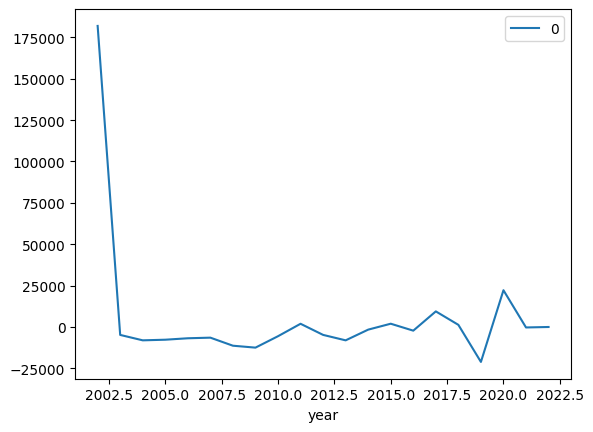

                   0
count      21.000000
mean     5561.964648
std     41320.480190
min    -21155.984278
25%     -7730.766814
50%     -4816.379200
75%      1257.063124
max    181956.669621


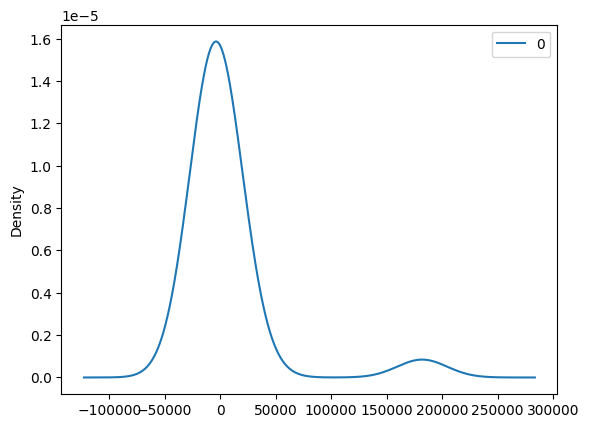

In [ ]:
#trying another p,d,q parameter based on our previous gridsearch result: 1,1,1
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot


# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA


#fitting model
model = ARIMA(total_emissions, order=(1,1,1)) #model
model_fit=model.fit()  #fitting the model

#summary of fitting the model
print(model_fit.summary())

#line plot of residuals
residuals=DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

#density plot of residuals
residuals.plot(kind='kde')
pyplot.show

#summary stats of residuals
print(residuals.describe())

#our new mean using the (1,1,1) parameters is "5561.964648"
#this new mean is less than the (5,1,0) parameter from previous which was "6314.080300"
#from these mean values, we see that "5561.964648" is less than "6314.080300"
#therefore, the (1,1,1) seems like a better fit than the (5,1,0) parameters

#Trying to improve accuracy of test_emissions... and failing

year
2002    181956.669621
2003    184349.169186
2004    170492.279566
2005    166835.585518
2006    156517.870610
Name: emissions, dtype: float64


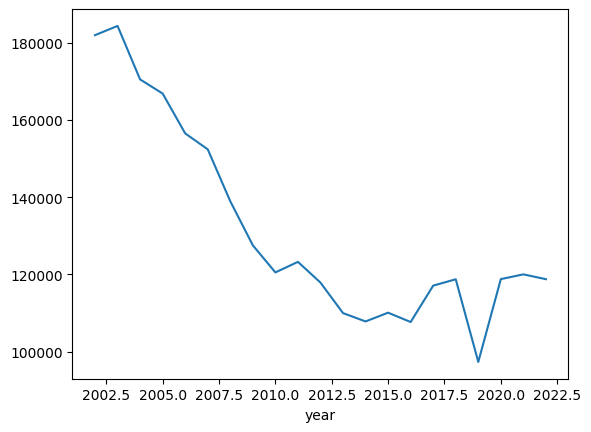

In [ ]:
from pandas import read_csv
from matplotlib import pyplot

#"total_emissions" is our dataset
print(total_emissions.head())
total_emissions.plot()
pyplot.show()

In [ ]:
# calculate residual errors for a persistence forecast model https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data --> our data is called "total_emissions"

# create lagged dataset
values = DataFrame(total_emissions.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model
predictions = [x for x in test_X]
# skill of persistence model
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.head())

Test RMSE: 13591.916
              0
0   1648.344855
1 -21401.174087
2  21445.652939
3   1225.332991
4  -1247.458937


In [ ]:
# autoregressive model of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
# load data --> our data is called "total_emissions"

# create lagged dataset
values = DataFrame(total_emissions.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AutoReg(train_resid, lags=5)
model_fit = model.fit()
print('Coef=%s' % (model_fit.params))

Coef=[ 5.27222813e+03  7.45853746e-01  3.74227684e-03  3.66804123e-01
  6.51774431e-01 -3.13391213e-01]


predicted error=14191.823815, expected error=1648.344855
predicted error=7805.619321, expected error=-21401.174087
predicted error=-9516.070713, expected error=21445.652939
predicted error=28692.189923, expected error=1225.332991
predicted error=-3462.387142, expected error=-1247.458937


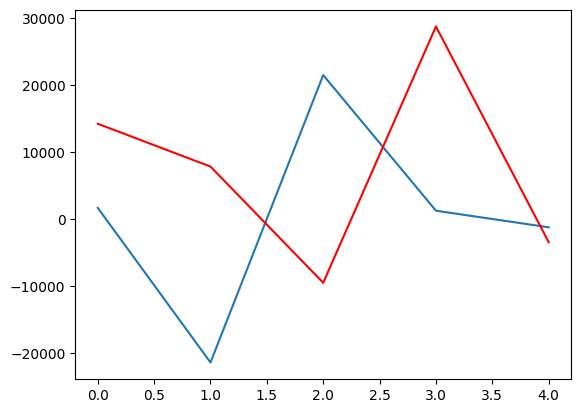

In [ ]:
# forecast residual forecast error
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot

# load data --> our data is called "total_emissions"
# create lagged dataset
values = DataFrame(total_emissions.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 5
model = AutoReg(train_resid, lags=window)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	expected_error.append(error)
	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]
	predictions.append(pred_error)
	history.append(error)
	print('predicted error=%f, expected error=%f' % (pred_error, error))
# plot predicted error
pyplot.plot(expected_error)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=131291.868068, expected=118748.389107
predicted=126554.008428, expected=97347.215020
predicted=87831.144308, expected=118792.867959
predicted=147485.057882, expected=120018.200950
predicted=116555.813808, expected=118770.742013
Test RMSE: 23359.530


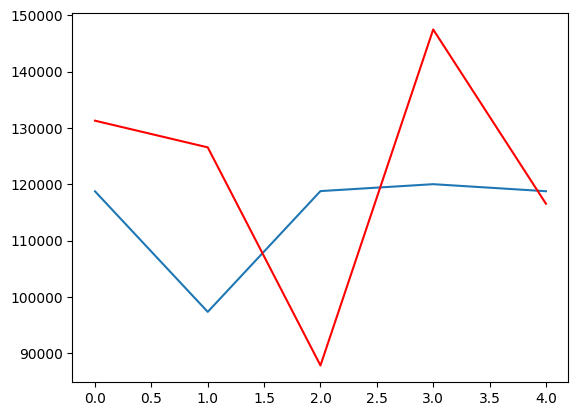

In [ ]:
# correct forecasts with a model of forecast residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data "total_emissions"
# create lagged dataset
values = DataFrame(total_emissions.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
# persistence model on training set
train_pred = [x for x in train_X]
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
window = 5
model = AutoReg(train_resid, lags=5)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_y)):
	# persistence
	yhat = test_X[t]
	error = test_y[t] - yhat
	# predict error
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	pred_error = coef[0]
	for d in range(window):
		pred_error += coef[d+1] * lag[window-d-1]

	# correct the prediction
	yhat = yhat + pred_error
	predictions.append(yhat)
	history.append(error)
	print('predicted=%f, expected=%f' % (yhat, test_y[t]))
# error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)
# plot predicted error
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

#RMSE score is worse than it was before (higher)

# Here, we will predict Pollutants
CO,
Black Carbon,
NH3,
NOX,
Organic Carbon,
PM10-PRI,
PM25-PRI,
SO2,
VOC

Modeled after Shiho's code: https://colab.research.google.com/drive/1sRqSZ4NAhZdR3xh98UBRO37iudf6tUTT?authuser=2#scrollTo=yKzdmpeio05y



**Carbon**

In [ ]:
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is CO
co_data = data_melted[data_melted['Pollutant'] == 'CO']

# Group by year and calculate the total emissions
total_CO = co_data.groupby(co_data['year'].dt.year)['emissions'].sum()

total_CO.info()

<class 'pandas.core.series.Series'>
Int64Index: 21 entries, 2002 to 2022
Series name: emissions
Non-Null Count  Dtype  
--------------  -----  
21 non-null     float64
dtypes: float64(1)
memory usage: 336.0 bytes


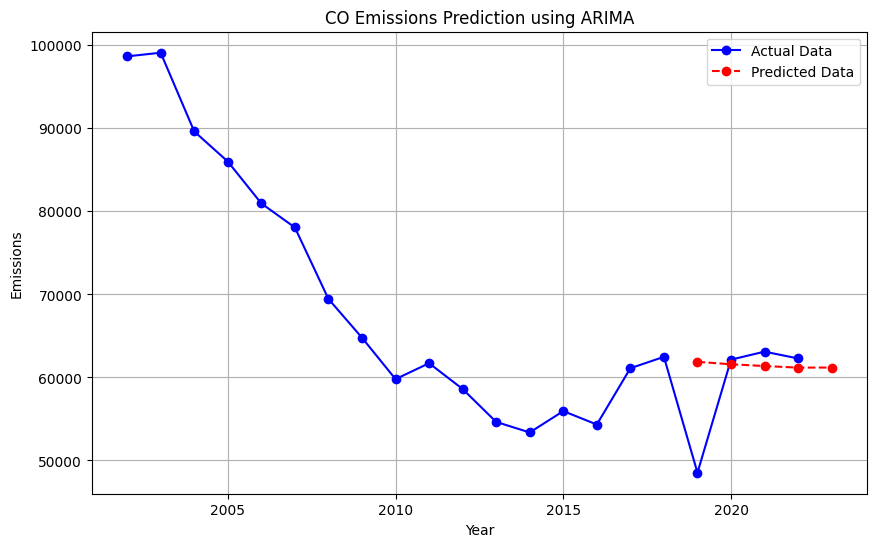

Residuals (predicted emissions - actual emissions): Year
2019    13354.346733
2020     -560.881268
2021    -1731.166266
2022    -1102.371622
2023             NaN
dtype: float64

Predicted values: Year
2019    61878.733457
2020    61584.713845
2021    61373.710174
2022    61181.878146
2023    61191.858053
Name: predicted_mean, dtype: float64


In [ ]:
#CO
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    98665.143057,
2003:    99103.335975,
2004:    89624.204086,
2005:    86000.975760,
2006:    80957.268625,
2007:    78056.969505,
2008:    69456.104440,
2009:    64783.860430,
2010:    59795.179663,
2011:    61711.269666,
2012:    58605.723663,
2013:    54641.548691,
2014:    53373.660417,
2015:    55945.469561,
2016:    54329.732779,
2017:    61110.870687,
2018:    62477.731469,
2019:    48524.386724,
2020:    62145.595113,
2021:    63104.876440,
2022:    62284.249768
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('CO Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()
#Sidenotes: how sensisitve time series are to more recent data [:18], [2020,2021,2022]
#if we had more data or better data, then we could make it less susceptible to things like this where its new points is based on new data
#other data wiht [:17] then it wouldve beenl ike this had covid not hit

#residual: the difference between predicted and expected value
#2019 the prediction was ~13354 higher because of covid
#other predictions are underpredicted hence why it's negative
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 61191.858053

**Black Carbon**

In [ ]:
#Black Carbon
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is CO
bc_data = data_melted[data_melted['Pollutant'] == 'Black Carbon']

# Group by year and calculate the total emissions
total_BC = bc_data.groupby(bc_data['year'].dt.year)['emissions'].sum()

total_BC

year
2002    482.229709
2003    491.717865
2004    477.059368
2005    471.847858
2006    453.021610
2007    419.969344
2008    393.578007
2009    361.198976
2010    361.157475
2011    343.181741
2012    318.933022
2013    300.764317
2014    284.526867
2015    276.221947
2016    316.757539
2017    261.631945
2018    260.297136
2019    232.658858
2020    376.241229
2021    376.468633
2022    373.140726
Name: emissions, dtype: float64

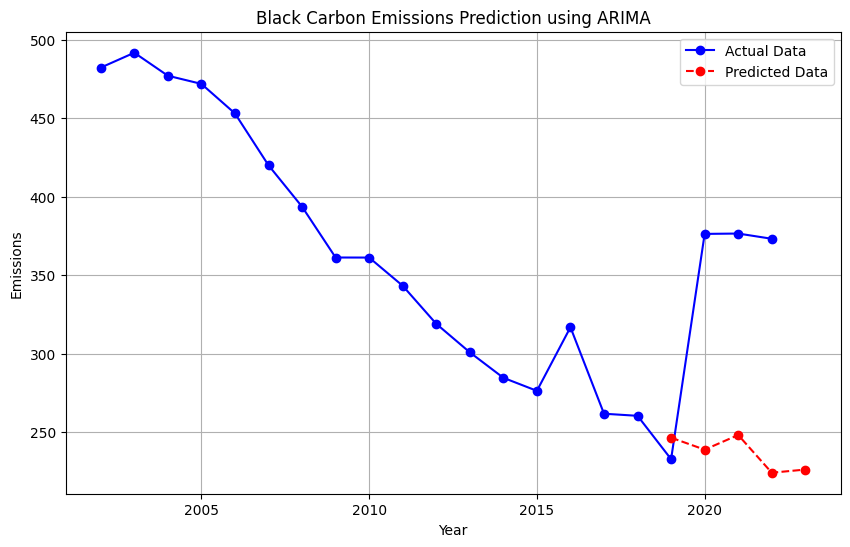

Residuals (predicted emissions - actual emissions): Year
2019     13.715745
2020   -137.509938
2021   -128.404774
2022   -149.113916
2023           NaN
dtype: float64

Predicted values: Year
2019    246.374603
2020    238.731291
2021    248.063859
2022    224.026810
2023    226.048087
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_BC
data = {
2002:    482.229709,
2003:    491.717865,
2004:    477.059368,
2005:    471.847858,
2006:    453.021610,
2007:    419.969344,
2008:    393.578007,
2009:    361.198976,
2010:    361.157475,
2011:    343.181741,
2012:    318.933022,
2013:    300.764317,
2014:    284.526867,
2015:    276.221947,
2016:    316.757539,
2017:    261.631945,
2018:    260.297136,
2019:    232.658858,
2020:    376.241229,
2021:    376.468633,
2022:   373.140726
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('Black Carbon Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 226.048087

**NH3**


In [ ]:
#NH3
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is CO
nh3_data = data_melted[data_melted['Pollutant'] == 'NH3']

# Group by year and calculate the total emissions
total_NH3 = nh3_data.groupby(nh3_data['year'].dt.year)['emissions'].sum()

total_NH3

year
2002    4352.153370
2003    4431.708292
2004    4338.925386
2005    4650.936173
2006    4520.673773
2007    4783.445126
2008    4595.968143
2009    4366.886052
2010    4437.303195
2011    4554.388489
2012    4544.474395
2013    4446.447866
2014    4334.258995
2015    4544.284519
2016    4604.094641
2017    4738.457612
2018    5217.204529
2019    5141.179095
2020    5481.004247
2021    5491.984640
2022    5490.902683
Name: emissions, dtype: float64

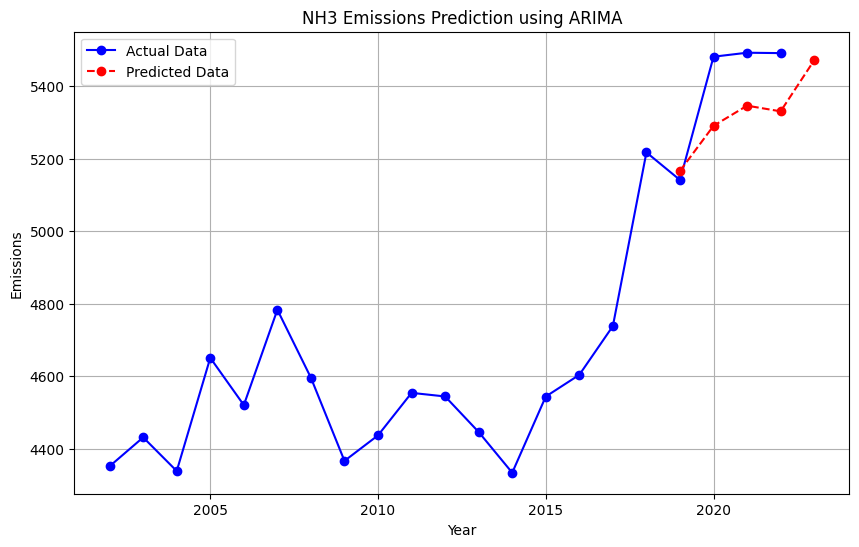

Residuals (predicted emissions - actual emissions): Year
2019     25.036672
2020   -190.524921
2021   -145.947866
2022   -160.489011
2023           NaN
dtype: float64

Predicted values: Year
2019    5166.215767
2020    5290.479326
2021    5346.036774
2022    5330.413672
2023    5471.105035
Name: predicted_mean, dtype: float64


In [ ]:
#NH3
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_NH3
data = {
2002:    4352.153370,
2003:    4431.708292,
2004:    4338.925386,
2005:    4650.936173,
2006:    4520.673773,
2007:    4783.445126,
2008:    4595.968143,
2009:    4366.886052,
2010:   4437.303195,
2011:   4554.388489,
2012:    4544.474395,
2013:    4446.447866,
2014:    4334.258995,
2015:    4544.284519,
2016:    4604.094641,
2017:    4738.457612,
2018:    5217.204529,
2019:    5141.179095,
2020:    5481.004247,
2021:    5491.984640,
2022:    5490.902683,
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('NH3 Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 5471.105035

**NO Nitrous Oxide**

In [ ]:
#NOX
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is NOX
nox_data = data_melted[data_melted['Pollutant'] == 'NOX']

# Group by year and calculate the total emissions
total_NOX = nox_data.groupby(nox_data['year'].dt.year)['emissions'].sum()

total_NOX

year
2002    25156.228284
2003    24515.236338
2004    22756.477544
2005    21769.426621
2006    20188.448559
2007    18834.225100
2008    17754.245808
2009    15449.385697
2010    15169.958081
2011    14471.719018
2012    13583.427561
2013    12753.543231
2014    12037.069864
2015    10992.710690
2016     9943.540045
2017     9414.492075
2018     9033.496297
2019     8529.517890
2020     7738.363608
2021     7797.781430
2022     7538.782407
Name: emissions, dtype: float64

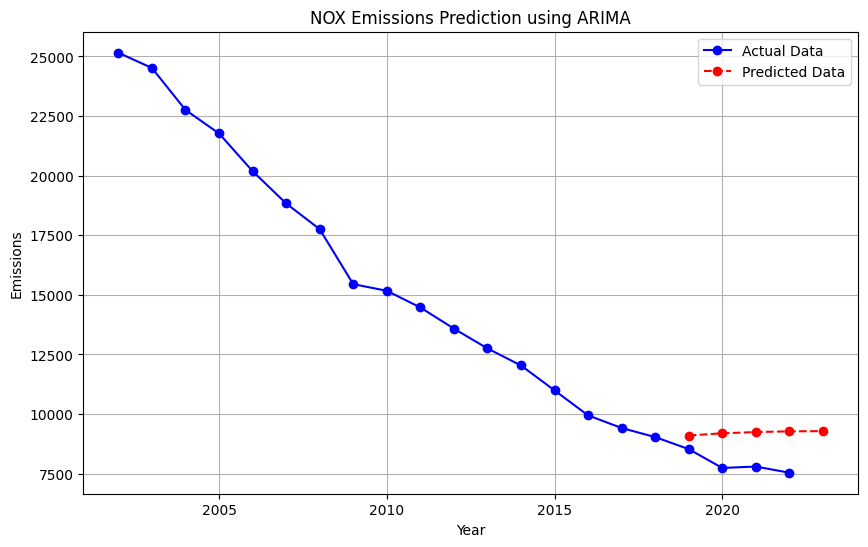

Residuals (predicted emissions - actual emissions): Year
2019     569.780480
2020    1454.424598
2021    1445.889891
2022    1736.514279
2023            NaN
dtype: float64

Predicted values: Year
2019    9099.298370
2020    9192.788206
2021    9243.671321
2022    9275.296686
2023    9282.954081
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    25156.228284,
2003:    24515.236338,
2004:    22756.477544,
2005:    21769.426621,
2006:    20188.448559,
2007:    18834.225100,
2008:    17754.245808,
2009:    15449.385697,
2010:    15169.958081,
2011:    14471.719018,
2012:    13583.427561,
2013:    12753.543231,
2014:    12037.069864,
2015:    10992.710690,
2016:     9943.540045,
2017:     9414.492075,
2018:     9033.496297,
2019:     8529.517890,
2020:     7738.363608,
2021:     7797.781430,
2022:     7538.782407,
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('NOX Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()


#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 9282.954081

**Organic Carbon**

In [ ]:
#Organic Carbon
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is OC
oc_data = data_melted[data_melted['Pollutant'] == 'Organic Carbon']

# Group by year and calculate the total emissions
total_OC = oc_data.groupby(oc_data['year'].dt.year)['emissions'].sum()

total_OC

year
2002    1136.318924
2003    1340.049911
2004    1274.139866
2005    1318.196596
2006    1279.756611
2007    1377.542077
2008    1254.417952
2009    1217.223826
2010    1169.098774
2011    1294.076348
2012    1230.744354
2013    1137.882561
2014    1136.822059
2015    1291.372451
2016    1473.186074
2017    1560.500666
2018    1582.007057
2019    1259.897610
2020    2102.515748
2021    2102.912275
2022    2101.113892
Name: emissions, dtype: float64

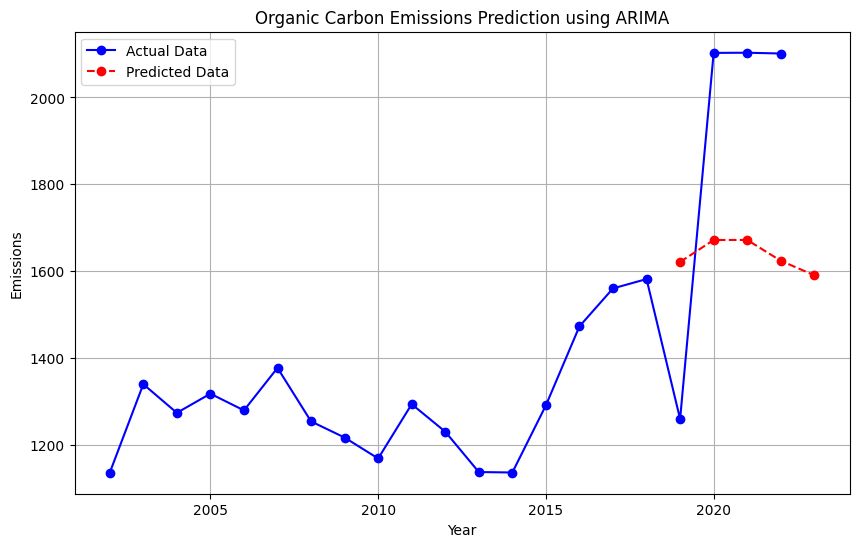

Residuals (predicted emissions - actual emissions): Year
2019    361.529086
2020   -430.640634
2021   -430.868221
2022   -477.029661
2023           NaN
dtype: float64

Predicted values: Year
2019    1621.426696
2020    1671.875114
2021    1672.044054
2022    1624.084231
2023    1590.737082
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    1136.318924,
2003:    1340.049911,
2004:    1274.139866,
2005:   1318.196596,
2006:    1279.756611,
2007:    1377.542077,
2008:    1254.417952,
2009:    1217.223826,
2010:    1169.098774,
2011:    1294.076348,
2012:    1230.744354,
2013:    1137.882561,
2014:    1136.822059,
2015:    1291.372451,
2016:    1473.186074,
2017:    1560.500666,
2018:    1582.007057,
2019:    1259.897610,
2020:    2102.515748,
2021:    2102.912275,
2022:   2101.113892
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('Organic Carbon Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 1590.737082

**PM10-PRI**

In [ ]:
#PM10-PRI
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is PM10-PRI
pm10_data = data_melted[data_melted['Pollutant'] == 'PM10-PRI']

# Group by year and calculate the total emissions
total_PM10 = pm10_data.groupby(pm10_data['year'].dt.year)['emissions'].sum()

total_PM10

year
2002    15320.287373
2003    15818.342114
2004    15455.499279
2005    16097.915090
2006    15302.554089
2007    15749.325776
2008    15255.983474
2009    14796.171751
2010    14786.925649
2011    15255.191552
2012    15510.497500
2013    14472.417348
2014    14588.782546
2015    15006.141903
2016    15586.667357
2017    16515.341943
2018    16218.684830
2019    14718.654856
2020    16741.055901
2021    16763.338469
2022    16761.080298
Name: emissions, dtype: float64

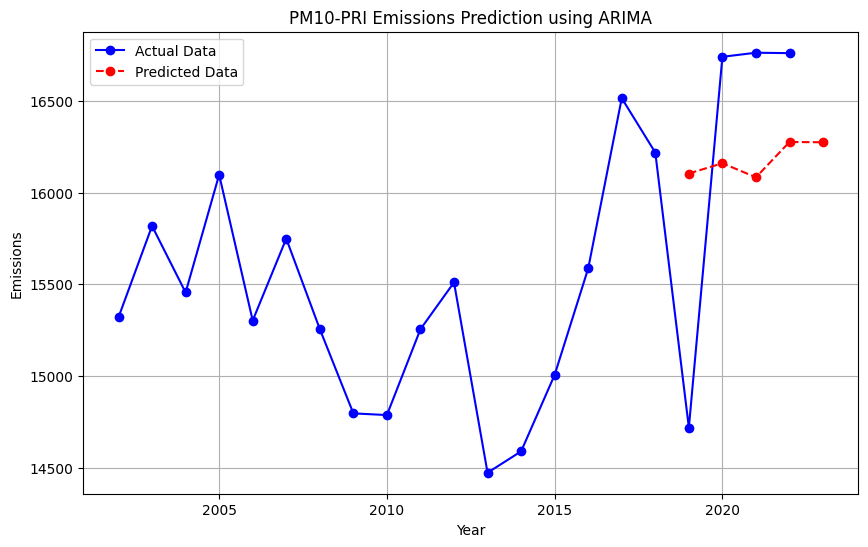

Residuals (predicted emissions - actual emissions): Year
2019    1385.719464
2020    -580.516165
2021    -679.482681
2022    -484.604887
2023            NaN
dtype: float64

Predicted values: Year
2019    16104.374320
2020    16160.539736
2021    16083.855788
2022    16276.475411
2023    16274.884773
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    15320.287373,
2003:    15818.342114,
2004:    15455.499279,
2005:    16097.915090,
2006:    15302.554089,
2007:    15749.325776,
2008:    15255.983474,
2009:    14796.171751,
2010:    14786.925649,
2011:    15255.191552,
2012:    15510.497500,
2013:    14472.417348,
2014:    14588.782546,
2015:    15006.141903,
2016:    15586.667357,
2017:    16515.341943,
2018:    16218.684830,
2019:    14718.654856,
2020:    16741.055901,
2021:    16763.338469,
2022:    16761.080298
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('PM10-PRI Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 16274.884773

**PM2.5-PRI**

In [ ]:
#PM25-PRI
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is PM25-PRI
pm25_data = data_melted[data_melted['Pollutant'] == 'PM25-PRI']

# Group by year and calculate the total emissions
total_PM25 = pm25_data.groupby(pm25_data['year'].dt.year)['emissions'].sum()

total_PM25

year
2002    4814.350228
2003    5246.873524
2004    5108.421261
2005    5251.241451
2006    5027.249528
2007    5081.637930
2008    4784.212947
2009    4517.746309
2010    4411.244251
2011    4739.897176
2012    4541.383459
2013    4220.689419
2014    4224.713182
2015    4505.005052
2016    4711.444785
2017    5362.520502
2018    5476.716230
2019    4338.604296
2020    5808.693385
2021    5814.200127
2022    5809.054622
Name: emissions, dtype: float64

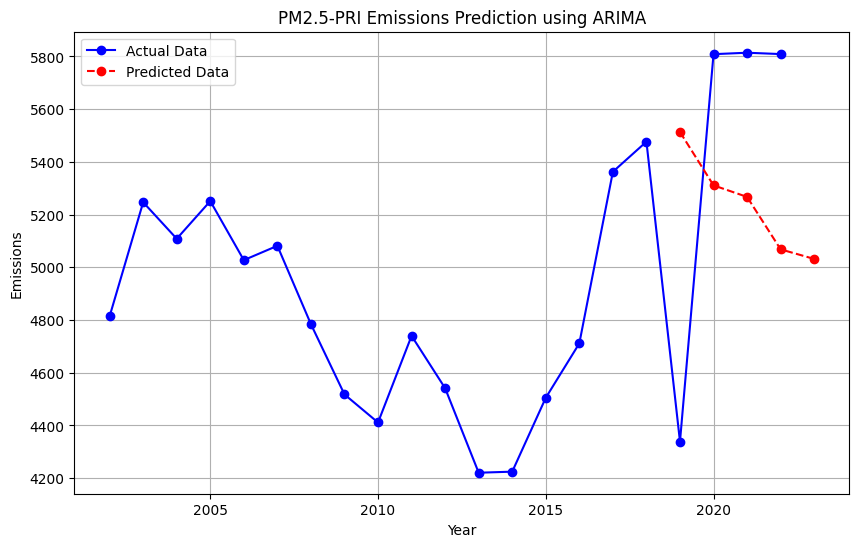

Residuals (predicted emissions - actual emissions): Year
2019    1174.787119
2020    -497.709863
2021    -547.049562
2022    -740.912896
2023            NaN
dtype: float64

Predicted values: Year
2019    5513.391415
2020    5310.983522
2021    5267.150565
2022    5068.141726
2023    5031.808817
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    4814.350228,
2003:    5246.873524,
2004:    5108.421261,
2005:    5251.241451,
2006:    5027.249528,
2007:    5081.637930,
2008:    4784.212947,
2009:    4517.746309,
2010:    4411.244251,
2011:    4739.897176,
2012:    4541.383459,
2013:    4220.689419,
2014:    4224.713182,
2015:    4505.005052,
2016:    4711.444785,
2017:    5362.520502,
2018:    5476.716230,
2019:    4338.604296,
2020:    5808.693385,
2021:    5814.200127,
2022:    5809.054622
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('PM2.5-PRI Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 5031.808817

**SO2**

In [ ]:
#SO2
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is SO2
so2_data = data_melted[data_melted['Pollutant'] == 'SO2']

# Group by year and calculate the total emissions
total_SO2 = so2_data.groupby(so2_data['year'].dt.year)['emissions'].sum()

total_SO2

year
2002    14821.715770
2003    15349.399468
2004    14606.024761
2005    14537.331663
2006    12431.129396
2007    11575.669050
2008    10157.476427
2009     7981.878881
2010     6880.759201
2011     6369.864975
2012     5059.506648
2013     4804.267280
2014     4553.565361
2015     3457.149820
2016     2659.788415
2017     2484.745273
2018     2387.942291
2019     1945.405394
2020     1826.517606
2021     1999.370188
2022     1914.526179
Name: emissions, dtype: float64

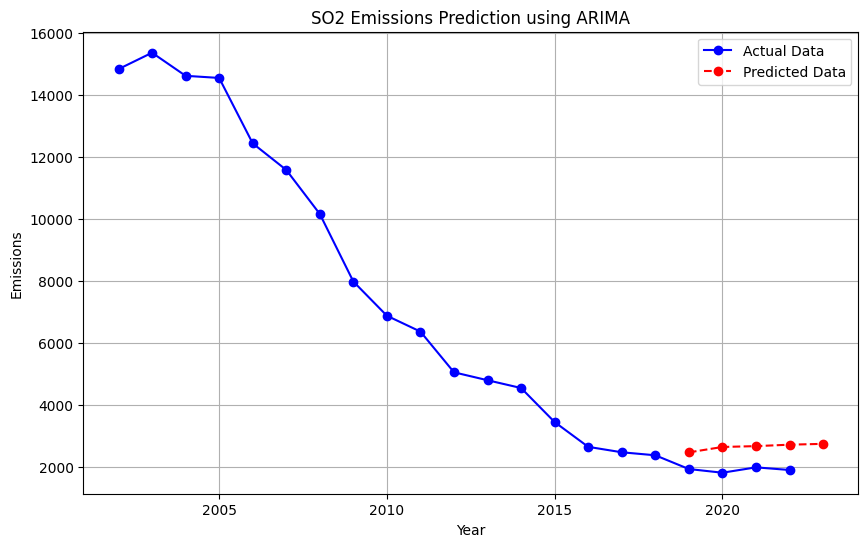

Residuals (predicted emissions - actual emissions): Year
2019    535.935513
2020    829.085291
2021    683.599240
2022    814.480048
2023           NaN
dtype: float64

Predicted values: Year
2019    2481.340907
2020    2655.602897
2021    2682.969428
2022    2729.006227
2023    2756.573607
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    14821.715770,
2003:    15349.399468,
2004:    14606.024761,
2005:    14537.331663,
2006:    12431.129396,
2007:    11575.669050,
2008:    10157.476427,
2009:     7981.878881,
2010:     6880.759201,
2011:     6369.864975,
2012:     5059.506648,
2013:     4804.267280,
2014:     4553.565361,
2015:     3457.149820,
2016:     2659.788415,
2017:     2484.745273,
2018:     2387.942291,
2019:     1945.405394,
2020:     1826.517606,
2021:     1999.370188,
2022:     1914.526179
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('SO2 Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 2756.573607

**VOC**

In [ ]:
#VOC
import pandas as pd
import numpy as np

data_melted['year'] = pd.to_datetime(data_melted['year'], format='%Y')

# Filter rows where the pollutant is VOC
voc_data = data_melted[data_melted['Pollutant'] == 'VOC']

# Group by year and calculate the total emissions
total_VOC = voc_data.groupby(voc_data['year'].dt.year)['emissions'].sum()

total_VOC

year
2002    17208.242906
2003    18052.505699
2004    16851.528015
2005    16737.714305
2006    16357.768418
2007    16513.543953
2008    15288.090996
2009    14064.830279
2010    13508.237588
2011    14517.078646
2012    14489.999036
2013    13208.830847
2014    13293.490349
2015    14078.649665
2016    14051.785424
2017    15651.483549
2018    16094.309269
2019    12656.910297
2020    16572.881122
2021    16567.268748
2022    16497.891438
Name: emissions, dtype: float64

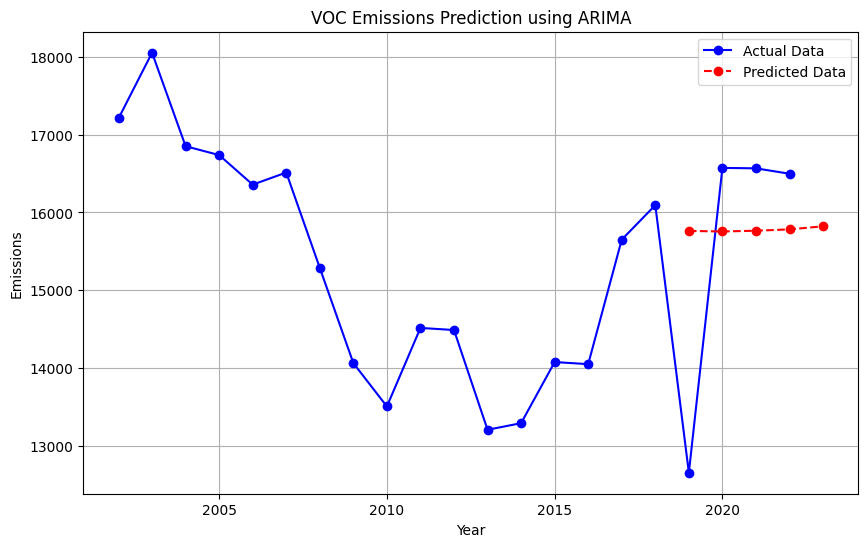

Residuals (predicted emissions - actual emissions): Year
2019    3106.190517
2020    -816.785652
2021    -801.412092
2022    -714.792383
2023            NaN
dtype: float64

Predicted values: Year
2019    15763.100814
2020    15756.095470
2021    15765.856656
2022    15783.099055
2023    15822.801339
Name: predicted_mean, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# from total_CO
data = {
2002:    17208.242906,
2003:    18052.505699,
2004:    16851.528015,
2005:    16737.714305,
2006:    16357.768418,
2007:    16513.543953,
2008:    15288.090996,
2009:    14064.830279,
2010:    13508.237588,
2011:    14517.078646,
2012:    14489.999036,
2013:    13208.830847,
2014:    13293.490349,
2015:    14078.649665,
2016:    14051.785424,
2017:    15651.483549,
2018:    16094.309269,
2019:   12656.910297,
2020:    16572.881122,
2021:   16567.268748,
2022:    16497.891438
}

# Convert the data to lists for plotting
years = list(data.keys())
emissions = list(data.values())

df = pd.DataFrame(list(data.items()), columns=['Year', 'Emissions'])
df.set_index('Year', inplace=True)

order = (5, 1, 0) #may need to adjust these parameters based on the data
model = ARIMA(df[:17], order=order)
fit = model.fit()

# make a change in years (for the original plot)
# note: Predict future values by dividing the total emissions to certain pollutants
# stick to ARIMA model and try to predict it multiple times(?)
# note: know the emission unit

future_years = [2019, 2020, 2021, 2022, 2023] #these are the years we are predicting, it includes 2019-2022 with data we already have; predicts 2023 for the future

forecast = fit.get_forecast(steps=len(future_years))
forecast_index = pd.Index(future_years, name='Year')
predicted_emissions = forecast.predicted_mean
predicted_emissions.index = forecast_index

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Emissions'], marker='o', linestyle='-', color='b', label='Actual Data')
plt.plot(predicted_emissions.index, predicted_emissions, marker='o', linestyle='--', color='r', label='Predicted Data')
plt.title('VOC Emissions Prediction using ARIMA')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()



#residuals
residual = predicted_emissions- df [17:]['Emissions']
print(f"Residuals (predicted emissions - actual emissions): {residual}\n") #residuals: difference between predicted and actual values
print(f"Predicted values: {predicted_emissions}") #these are the predicted values --> 2025 expects 15822.801339